__Import Libraries__

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(12)

# Consider 3-dimensional dataset.
dims = 3
nsamples = 20

# Mean Vector: Fill with zeros
mu_vec1 = np.zeros(3)


# Covariance matrix: Keep the matrix identity, to avoid linear transformation of coordinate system.
cov_mat1 = np.eye(3)


# Draw 20 random samples from multivariate normal distributions.
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, nsamples)


# Convert these samples to a dataframe.
df1 = pd.DataFrame(class1_sample, columns=["Feature1", "Feature2", "Feature3"])
df1["target"] = 0


## Repeat with mean vector => 1, for different target.
# Mean Vector: Fill with ones
mu_vec2 = np.ones(3)


# Draw 20 random samples from multivariate normal distributions.
class1_sample = np.random.multivariate_normal(mu_vec2, cov_mat1, nsamples)


# Convert these samples to a dataframe.
df2 = pd.DataFrame(class1_sample, columns=["Feature1", "Feature2", "Feature3"])
df2["target"] = 1


# Final dataset
df = pd.concat([df1, df2], axis=0, ignore_index=True)
df = df.sample(nsamples*2).reset_index().drop("index", axis=1)

In [3]:
print(df.shape)
df.head()

(40, 4)


,Feature1,Feature2,Feature3,target
0,1.335831,0.318665,-0.337595,0
1,-0.997204,-0.713856,0.035416,0
2,1.943575,1.357644,0.916551,1
3,2.828821,-0.001002,-1.091691,1
4,-0.122150,1.012515,-0.913869,0


__Visualize Data__

In [4]:
fig = px.scatter_3d(df, 
                    x=df["Feature1"], 
                    y=df["Feature2"], 
                    z=df["Feature3"],
                    color=df["target"].astype("str")
                    )

fig.update_traces(
                marker=dict(size=8,
                            line=dict(
                                width=4,
                                color="DarkSlateGrey")),

                selector=dict(mode="markers"))

fig.show()

__Apply Standard Scaling__

 To transform the datapoints into mean centric.

In [5]:
scaler = StandardScaler()
df.iloc[:, :3] = scaler.fit_transform(df.iloc[:, :3])

__Find Covariance Matrix__

$$Covariance~Matrix : 
\begin{bmatrix}Var(x)&Cov(x,y)&Cov(x,z)\cr 
Cov(y,x)&Var(y)&Cov(y,z)\cr 
Cov(z,x)&Cov(z,y)&Var(z)\end{bmatrix}$$


In [6]:
cov_matrix = np.cov([df["Feature1"], df["Feature2"], df["Feature3"]])
cov_matrix

array([[1.02564103, 0.08674662, 0.35311467],
       [0.08674662, 1.02564103, 0.21362628],
       [0.35311467, 0.21362628, 1.02564103]])

__Find Eigen Decomposition__

In [7]:
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

In [8]:
eigen_values

array([1.4802192 , 0.64712315, 0.94958073])

In [9]:
eigen_vectors

array([[-0.60349399, -0.62249119,  0.49829682],
       [-0.43055748, -0.27158827, -0.86073228],
       [-0.67112984,  0.73399218,  0.10411635]])

__Plot Eigen Vectors to visualize them in 3D Space__

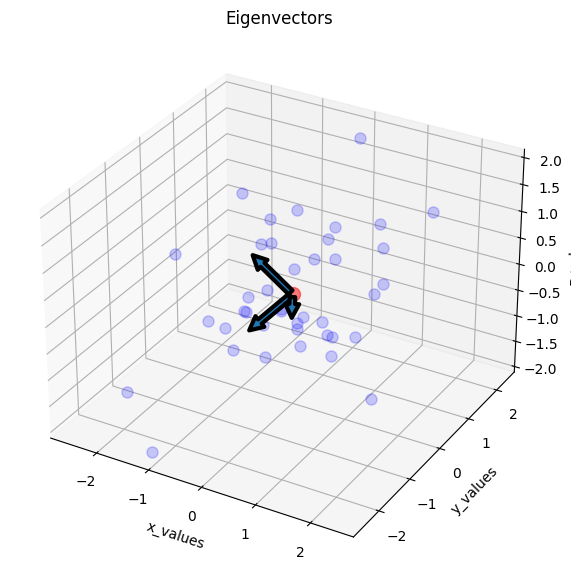

In [10]:
%matplotlib inline

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self,(0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        
        return np.min(zs)

    
fig  = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection="3d")

ax.plot(df["Feature1"], df["Feature2"], df["Feature3"], 'o', markersize=8, color="blue", alpha=0.2)
ax.plot([df["Feature1"].mean()], [df["Feature2"].mean()], [df["Feature3"].mean()],'o', markersize=10, color="red", alpha=0.5)

for v in eigen_vectors.T:
    a = Arrow3D([df["Feature1"].mean(), v[0]], [df["Feature2"].mean(), v[1]], [df["Feature3"].mean(), v[2]], mutation_scale=20, lw=3)
    ax.add_artist(a)

ax.set_xlabel("x_values")
ax.set_ylabel("y_values")
ax.set_zlabel("z_values")

plt.title("Eigenvectors")
plt.show()

In [11]:
pc = eigen_vectors[:2]

$$PC_1~:~~[~-0.60349399~~-0.62249119~~0.49829682~]$$
$$PC_2~:~~[~-0.43055748~~-0.27158827~~-0.86073228~]$$

__Transform 3D data to 2D data__

In [12]:
transformed_df = np.dot(df.iloc[:,:3], pc.T)

new_df = pd.DataFrame(transformed_df, columns=["PC1", "PC2"])
new_df["target"] = df.target.values
new_df.head()

,PC1,PC2,target
0,-0.795765,0.326823,0
1,1.020331,0.994924,0
2,-1.108280,-1.199572,1
3,-1.576079,0.608399,1
4,-0.918649,1.047528,0


__Finally, Plot this 2D data into a 2-Dimensional Graph__

In [13]:
fig = px.scatter(x = new_df.PC1,
                 y = new_df.PC2,
                 color = new_df["target"].astype('str'),
                 color_discrete_sequence=px.colors.qualitative.G10
                 )

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color="DarkSlateGrey")),
                  selector=dict(mode="markers"))

fig.show()

This is the required `snapshot` of the 3D dataset.